# GNN Turbulence Model
## Load in dataset
### Dataset is in cartesian, convert to staggered points in 

In [2]:
import sys
import numpy as np
import torch
from tqdm.notebook import tqdm


# %matplotlib ipympl
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
from cmap import Colormap
from matplotlib import pyplot as plt
### standard parameters
plt.rcParams['figure.figsize'] = (6, 2)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['animation.embed_limit'] = 2**128
icefire_mpl = Colormap('icefire').to_matplotlib()
try:
    plt.colormaps.register(icefire_mpl, name='icefire')
except:
    pass
plt.rcParams["image.cmap"] = 'icefire'

import matplotlib.animation as animation
from IPython.display import HTML

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.spatial import Voronoi, Delaunay

from models.models import *
from models.tmp_models import *
from src.mesh_util import *
from src.data_util import *

In [3]:
# load data

# filenames = {'baseline_64': 'kolmogorov_re_1000/eval_2048x2048_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000/long_eval_2048x2048_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000/eval_64x64_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000_fig1/baseline_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000_fig1/baseline_256x256.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000_fig1/baseline_2048x2048.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_4000/eval_128x128_128x128.nc'}
# filenames = {'baseline_64': 'decaying/eval_1024x1024_64x64.nc'}
filenames = {'baseline_64': 'decaying/eval_2048x2048_64x64.nc'}

data = load_dataset(filenames,path='data/')
data = data['baseline_64']
dt = data.stable_time_step
dt = (data.time[1]-data.time[0]).data

x_range = (data.x.min().item(),data.x.max().item())
y_range = (data.y.min().item(),data.y.max().item())

x_range = (0,2*np.pi)
y_range = (0,2*np.pi)

print(x_range,y_range)
print(dt)


(0, 6.283185307179586) (0, 6.283185307179586)
0.07012483601762931


## Mesh Creation


In [4]:

# setup mesh

rows = 64
cols = 64

# rows = 32
# cols = 32

rows = 16
cols = 16


staggered_points = np.empty((rows,cols,2))

dx = (x_range[1]-x_range[0])/(rows)
dy = (y_range[1]-y_range[0])/(cols)
staggered_points[:,:,1] = np.arange(y_range[0],y_range[1]-dy/10,dy)[:,np.newaxis]
for i in range(rows):
    point_row = np.arange(x_range[0],x_range[1]-6*dx/10,dx)
    # staggered_points[i,:,0] = point_row + i%2*(dx/2) # stagger
    staggered_points[i,:,0] = point_row 

staggered_points = staggered_points.reshape(-1,2)

original_spacing = (data.x.max().values - data.x.min().values)/64
# mesh, connectivity, connectivity_periodic, edge_attr, edge_attr_periodic = delanay_mesh_constructor(staggered_points,periodic=True,bidirectional=True,periodic_limits=np.array([[x_range[0],x_range[1]],[y_range[0],y_range[1]]]))
mesh, connectivity, connectivity_periodic, edge_attr, edge_attr_periodic = cartesian_mesh_contructor(staggered_points,periodic=True,bidirectional=True,periodic_limits=np.array([[x_range[0],x_range[1]],[y_range[0],y_range[1]]]))

# combine connectivities
connectivity_combined = np.concatenate([connectivity,connectivity_periodic],axis=1)

# combine relative position
edge_attr_combined = np.concat([edge_attr,edge_attr_periodic],axis=0)


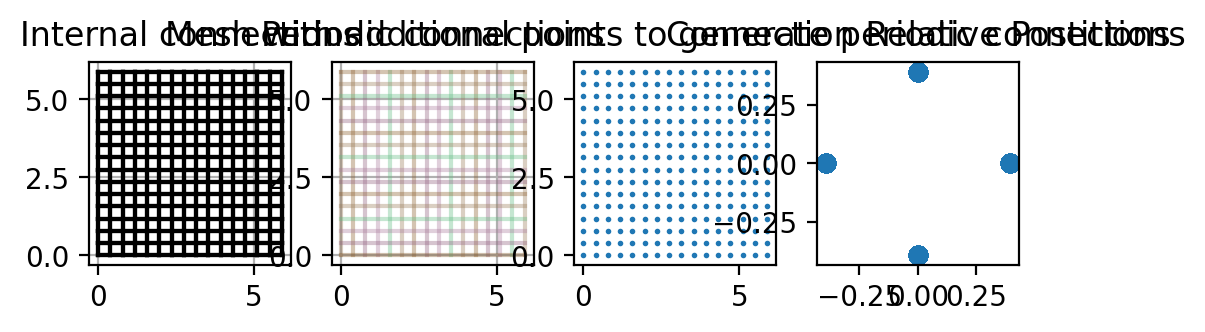

In [5]:
# fig = plt.figure(figsize=(16,6),dpi=300)
fig = plt.figure()
ax = fig.add_subplot(141)
ax.plot(staggered_points[connectivity,0],staggered_points[connectivity,1],c='k')
ax.set_aspect('equal')
ax.set_title('Internal connections')
ax.grid(True)
ax = fig.add_subplot(142)
ax.plot(staggered_points[connectivity_periodic,0],staggered_points[connectivity_periodic,1],alpha=0.2)
ax.set_title('Periodic connections')
ax.set_aspect('equal')
ax.grid(True)

# fig = plt.figure(figsize=(6,6),dpi=300)
ax = fig.add_subplot(143)
ax.scatter(staggered_points[:,0],staggered_points[:,1],s=1)
ax.set_title('Mesh with additional points to generate periodic connections')
ax.set_aspect('equal')
# plt.show()

# fig = plt.figure(figsize=(16,5),dpi=300)
ax = fig.add_subplot(144)
ax.scatter(edge_attr_combined[:,0],edge_attr_combined[:,1])
ax.set_aspect('equal')
ax.set_title('Connection Relative Postitions')
plt.show()

## Interpolation of values
### Original data is in cartesian system. Convert to polygon points from previously generated mesh

In [6]:
from scipy.interpolate import RegularGridInterpolator

rho = 1.0


# plot figures
timestep = 0
sample_ind = 0

sample_inds = data.sample
time_arr = data.time


# periodicity of domain
x = np.empty(len(data.x)+2)
y = np.empty(len(data.y)+2)
x[1:-1] = data.x
y[1:-1] = data.y

x[0] = data.x[0] - (data.x[1]-data.x[0])
x[-1] = data.x[-1] + (data.x[-1]-data.x[-2])
y[0] = data.y[0] - (data.y[1]-data.y[0])
y[-1] = data.y[-1] + (data.y[-1]-data.y[-2])

u = np.empty((*data.u.shape[:2],data.u.shape[2]+2,data.u.shape[3]+2))
v = np.empty((*data.u.shape[:2],data.v.shape[2]+2,data.v.shape[3]+2))
u[:,:,1:-1,1:-1] = data.u
v[:,:,1:-1,1:-1] = data.v
u[:,:,0] = u[:,:,-2]
v[:,:,0] = v[:,:,-2]
u[:,:,-1] = u[:,:,1]
v[:,:,-1] = v[:,:,1]
u[:,:,:,0] = u[:,:,:,-2]
v[:,:,:,0] = v[:,:,:,-2]
u[:,:,:,-1] = u[:,:,:,1]
v[:,:,:,-1] = v[:,:,:,1]

# velocity data saved on staggered grid. Linear interpolation to node center
u = 0.5*(np.roll(u,shift=1,axis=-2)+u)
v = 0.5*(np.roll(v,shift=1,axis=-2)+v)

interp_u = RegularGridInterpolator([data.sample,data.time,x,y],u,bounds_error=False)
interp_v = RegularGridInterpolator([data.sample,data.time,x,y],v,bounds_error=False)

# reshape with samples and time steps
# extend last dimension by 2 to include sample and time info
staggered_points_full_set = np.tile(staggered_points,[len(data.sample),len(data.time),1,2])
staggered_points_full_set[:,:,:,0] = data.sample.to_numpy()[:,np.newaxis,np.newaxis]
staggered_points_full_set[:,:,:,1] = data.time.to_numpy()[np.newaxis,:,np.newaxis]
flattened = staggered_points_full_set.reshape(-1,4) # [[sample, time, x, y], ...]

staggered_points_u = interp_u(flattened) # [u, ...]
staggered_points_v = interp_v(flattened)

staggered_points_full_set_vel = np.stack([staggered_points_u.reshape(len(data.sample),len(data.time),rows,cols),staggered_points_v.reshape(len(data.sample),len(data.time),rows,cols)],axis=4)


AttributeError: 'Dataset' object has no attribute 'vorticity'

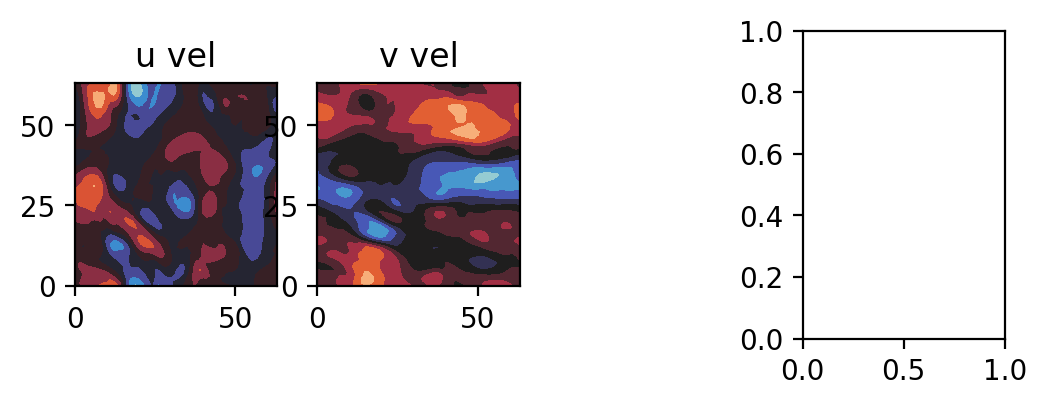

In [7]:

# fig = plt.figure(figsize=(4,2),dpi=300)
fig = plt.figure()
ax = fig.add_subplot(141)
ax.contourf(data.u[sample_ind,timestep])
ax.set_aspect('equal')
ax.set_title('u vel')
ax = fig.add_subplot(142)
ax.contourf(data.v[sample_ind,timestep])
ax.set_aspect('equal')
ax.set_title('v vel')
# ax = fig.add_subplot(143)
# ax.contourf(data.pressure[sample_ind,timestep])
# ax.set_aspect('equal')
# ax.set_title('pressure')
ax = fig.add_subplot(144)
ax.contourf(data.vorticity[sample_ind,timestep])
ax.set_aspect('equal')
ax.set_title('vorticity')


plt.show()

# fig = plt.figure(figsize=(1,2),dpi=300)
fig = plt.figure()
ax = fig.add_subplot(141)
ax.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),staggered_points_full_set[0,0,:,3].flatten(),staggered_points_full_set_vel[0,0,:,:,0].flatten())
ax.set_aspect('equal')
ax.set_title('u vel')
ax = fig.add_subplot(142)
ax.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),staggered_points_full_set[0,0,:,3].flatten(),staggered_points_full_set_vel[0,0,:,:,1].flatten())
ax.set_aspect('equal')
ax.set_title('v vel')
# ax = fig.add_subplot(143)
# ax = fig.add_subplot(144)
plt.show()

# animate interpolated value evolution



# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import matplotlib.tri as tri
# import numpy as np

# 1. Initial plot
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

levels = np.linspace(-3, 3, 20)
tcf1 = ax1.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),
                        staggered_points_full_set[0,0,:,3].flatten(),
                        staggered_points_full_set_vel[0,0,:,:,0].flatten(), levels=levels)
tcf2 = ax2.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),
                        staggered_points_full_set[0,0,:,3].flatten(),
                        staggered_points_full_set_vel[0,0,:,:,1].flatten(), levels=levels)
tcf3 = ax3.contourf(data.u[sample_ind,0].T, levels=levels)
tcf4 = ax4.contourf(data.v[sample_ind,0].T, levels=levels)

ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')

fig.colorbar(tcf1)
fig.colorbar(tcf2)
fig.colorbar(tcf3)
fig.colorbar(tcf4)

def animate(i):
    global tcf1,tcf2,tcf3,tcf4
    # Directly call remove on the TriContourSet object
    if tcf1:
        tcf1.remove()
    if tcf2:
        tcf2.remove()   
    if tcf3:
        tcf3.remove()
    if tcf4:
        tcf4.remove()
    # Draw the new tricontourf
    tcf1 = ax1.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),
                         staggered_points_full_set[0,0,:,3].flatten(),
                         staggered_points_full_set_vel[0,i,:,:,0].flatten(), levels=levels)
    tcf2 = ax2.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),
                            staggered_points_full_set[0,0,:,3].flatten(),
                            staggered_points_full_set_vel[0,i,:,:,1].flatten(), levels=levels)
    tcf3 = ax3.contourf(data.u[sample_ind,i].T, levels=levels)
    tcf4 = ax4.contourf(data.v[sample_ind,i].T, levels=levels)
    
    ax1.set_title(f'Frame: {i}')
    
    # Since ContourSet is now a single artist, return it directly for blitting
    return (tcf1,tcf2,tcf3,tcf4)

# 3. Create the animation (blit=True is now supported)
anim = animation.FuncAnimation(fig, animate, frames=staggered_points_full_set_vel.shape[1]-1, 
                               interval=40, blit=True)

plt.show()
# HTML(anim.to_jshtml())


## Training Setup

In [8]:
ind_skip = 1
unroll_inds = 10
unroll_inds = 0
device = 'cuda'

dt_skip = ind_skip*dt
skip = staggered_points_full_set_vel[:,::ind_skip]
train_test_split = 0.8

train_data = skip[:int(skip.shape[0]*train_test_split)]
test_data = skip[int(skip.shape[0]*train_test_split):]

# torch.randperm()


# set device
e = torch.tensor(edge_attr_combined,dtype=torch.float32).to(device)
train_input = torch.tensor(train_data[:,:-1-unroll_inds],dtype=torch.float32).to(device)
train_target = torch.tensor(train_data[:,1:train_data.shape[1]-unroll_inds],dtype=torch.float32).to(device)
if unroll_inds > 0:
    train_unrolled_target = torch.tensor(train_data[:,1+unroll_inds:],dtype=torch.float32).to(device)
train_target = (train_target - train_input)/dt_skip
print(train_input.mean())
print(train_input.std())
print(train_target.mean())
print(train_target.std())

test_input = torch.tensor(test_data[:,:-1-unroll_inds],dtype=torch.float32).to(device)
test_target = torch.tensor(test_data[:,1:test_data.shape[1]-unroll_inds],dtype=torch.float32).to(device)
if unroll_inds > 0:
    test_unrolled_target = torch.tensor(test_data[:,1+unroll_inds:],dtype=torch.float32).to(device)
test_target = (test_target - test_input)/dt_skip
# tmp = test_target.detach().clone()
# tmp = tmp.reshape(tmp.shape[0],tmp.shape[1],rows*cols,2)

ij = torch.tensor(connectivity_combined,dtype=torch.long).to(device)

train_input = train_input.reshape(-1,rows*cols,2)
test_input = test_input.reshape(-1,rows*cols,2)
train_target = train_target.reshape(-1,rows*cols,2)
test_target = test_target.reshape(-1,rows*cols,2)
if unroll_inds > 0:
    train_unrolled_target = train_unrolled_target.reshape(-1,rows*cols,2)
    test_unrolled_target = test_unrolled_target.reshape(-1,rows*cols,2)

print(train_input.shape)
print(test_input.shape)
print(train_target.shape)
print(test_target.shape)
print(ij.shape)
print(e.shape)



tensor(-0.0003, device='cuda:0')
tensor(0.9797, device='cuda:0')
tensor(-1.3471e-05, device='cuda:0')
tensor(0.6503, device='cuda:0')
torch.Size([7308, 256, 2])
torch.Size([2436, 256, 2])
torch.Size([7308, 256, 2])
torch.Size([2436, 256, 2])
torch.Size([2, 1024])
torch.Size([1024, 2])


## Testing

### Not sure what density is

### Calculate from navier stokes equations (incompressible) with non dimensionalized length and time scales with reynolds number 

$\frac{\partial u_i}{\partial t} = - \frac{d p}{\rho d x_i} - u_j \frac{\partial u_i}{\partial x_j} + \frac{1}{Re} \frac{\partial^2 u_j}{\partial x_i \partial x_j}$


$\frac{du_i}{dx_i} = 0$

### Filtered Navier stokes

In [21]:
rows = 16
cols = 16
sample_ind = 0
t = 0

tmp = torch.zeros(*staggered_points_full_set_vel.shape[:2],rows,cols,2)
tmp[:,:,:,:,:] += torch.arange(rows)[torch.newaxis,torch.newaxis,:,torch.newaxis]
tmp = tmp.reshape(*tmp.shape[:2],rows*cols,2)

vs = torch.Tensor(staggered_points_full_set_vel).to(device)
# vs = tmp.to(device)
vs = vs.reshape(*tmp.shape[:2],rows*cols,2)

distance = (((e[ij[0]])**2).sum(1))
weighting = 1/(distance)

# 1. Pre-calculate indices for batching
# Assuming ij[0] contains the indices [0, 0, ..., 1, 1, ..., N-1]
unique_indices, counts = torch.unique(ij[0], return_counts=True)
num_batches = vs.shape[2]
max_rows = counts.max().item()

# 2. Prepare padded tensors (N, max_rows, cols)
# We use padding because different 'i' might have different numbers of edges
E_batched = torch.zeros(num_batches, max_rows, 2, device=device)
W_batched = torch.zeros(num_batches, max_rows, max_rows, device=device)

# 3. Vectorized filling (requires careful indexing or scatter)
# If edges per vertex are uniform, you can reshape directly. 
# If non-uniform, use a helper to fill the batched tensor:
for i in range(num_batches):
    mask = (ij[0] == i)
    rows = e[mask]
    E_batched[i, :rows.size(0), :] = rows
    # Weighting is diagonal, so we can use a simpler vector form later
    W_diag = weighting[mask]
    W_batched[i, :rows.size(0), :rows.size(0)] = torch.diag(W_diag)

# 4. Batched Weighted Least Squares calculation
# Formula: (D^T W^T W D)^-1 D^T W^T W
# For efficiency, replace explicit inv() with solve() where possible
ET = E_batched.transpose(1, 2)
WTW = W_batched.transpose(1, 2) @ W_batched # Batched matrix multiply
G = ET @ WTW @ E_batched

# Use torch.linalg.solve for better stability and speed than inv()
# We want: mat = G^-1 @ (ET @ WTW)
# This is equivalent to solving G @ mat = (ET @ WTW)
rhs = ET @ WTW
inv_square_mesh_mat1 = torch.linalg.solve(G, rhs) # Shape: (N, 2, 4)

sort_inds = torch.argsort(ij[0])
difference = vs[sample_ind,t,ij[0]] - vs[sample_ind,t,ij[1]]
difference = difference[sort_inds]

# 1. Prepare padded difference tensor (N, max_conn, 3)
# diff has shape (total_edges, 3)
unique_idx, counts = torch.unique(ij[0], return_counts=True)
max_conn = counts.max().item()
num_nodes = vs.shape[2]

diff_padded = torch.zeros(num_nodes, max_conn, 2, device=device)

# Fill padded difference (using the same logic as the matrix padding)
# We use the pre-sorted 'difference' to match the index order
curr_ptr = 0
for i, count in enumerate(counts):
    diff_padded[i, :count, :] = difference[curr_ptr : curr_ptr + count]
    curr_ptr += count

# 2. Batched Matrix Multiplication
# inv_square_mesh_mat: (N, 4, max_conn)
# diff_padded:         (N, max_conn, 3)
# Result:              (N, 4, 3)
gradients = torch.bmm(inv_square_mesh_mat1, diff_padded)

# print(result)


In [22]:
rows = 16
cols = 16
# divergence = gradients[:,:,:,0,0] + gradients[:,:,:,1,1]
divergence = gradients[:,0,0] + gradients[:,1,1]

divergence = divergence.cpu().numpy()
# print(divergence[0,0,:16])

time_ind = 0
# print(np.abs(divergence[0,time_ind]).mean())
# print(np.abs(divergence[0,time_ind]).max())
# print(divergence[0,time_ind].std())
print(np.abs(divergence).mean())
print(np.abs(divergence).max())
print(divergence.std())


# divergence = gradients[:,:,:,0,1] + gradients[:,:,:,1,0]
# divergence = divergence.cpu().numpy()
# # print(divergence[0,0,:16])
# print(np.abs(divergence[0,-1]).mean())
# print(divergence[0,-1].std())

v_tmp = staggered_points_full_set_vel.reshape(*staggered_points_full_set_vel.shape[:2],rows,cols,2)
# v_tmp = tmp.reshape(*tmp.shape[:2],rows,cols,2)
v_pos_tmp = staggered_points.reshape(rows,cols,2)

uu = v_tmp[:,:,:,:,0]**2
uv = v_tmp[:,:,:,:,0]*v_tmp[:,:,:,:,1]
# dudx = np.gradient(data.u,axis=-2)/np.gradient(data.x)[np.newaxis,np.newaxis,:,np.newaxis]
# dvdy = np.gradient(data.v,axis=-1)/np.gradient(data.y)[np.newaxis,np.newaxis,np.newaxis,:]

duudx = np.gradient(uu,axis=-2)/np.gradient(v_pos_tmp[:,:,0],axis=-1)[np.newaxis,np.newaxis,:,:]
duvdy = np.gradient(uv,axis=-1)/np.gradient(v_pos_tmp[:,:,1],axis=-2)[np.newaxis,np.newaxis,:,:]
# dudx = np.gradient(v_tmp[:,:,:,:,0],axis=-1)/np.gradient(v_pos_tmp[:,:,0],axis=-1)[np.newaxis,np.newaxis,:,:]
# dvdy = np.gradient(v_tmp[:,:,:,:,1],axis=-2)/np.gradient(v_pos_tmp[:,:,1],axis=-2)[np.newaxis,np.newaxis,:,:]
dudx = (np.roll(v_tmp[:,:,:,:,0],-1,axis=-1)-np.roll(v_tmp[:,:,:,:,0],1,axis=-1))/np.gradient(v_pos_tmp[:,:,0],axis=-1)[np.newaxis,np.newaxis,:,:]/2
dvdy = (np.roll(v_tmp[:,:,:,:,1],-1,axis=-2)-np.roll(v_tmp[:,:,:,:,1],1,axis=-2))/np.gradient(v_pos_tmp[:,:,1],axis=-2)[np.newaxis,np.newaxis,:,:]/2
divergence = dudx + dvdy
# print(divergence[0,-1,2])
print(np.abs(divergence[0,time_ind]).mean())
print(divergence[0,time_ind].std())




0.2953155
1.1942012
0.37429494
0.29531549766164616
0.3742949459145521


In [ ]:
print(data.attrs)
print(data.seed)
print(data.warmup_time)
print(data.simulation_time)
print(data.maximum_velocity)
print(data.time_subsample_factor)
print(data.init_cfl_safety_factor)
print(data.stable_time_step)